In [96]:
import pydicom
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
import imutils
from pprint import pp

In [146]:
path = r"C:\Users\M305747\OneDrive - Mayo Clinic\MPC\medical-physics\NM\Flood Analysis\flood"
img = pydicom.dcmread(path)
pixels1 = img.pixel_array[0,:,:] #flood head 1, reported uniformity 2.15%
pixels2 = img.pixel_array[1,:,:]

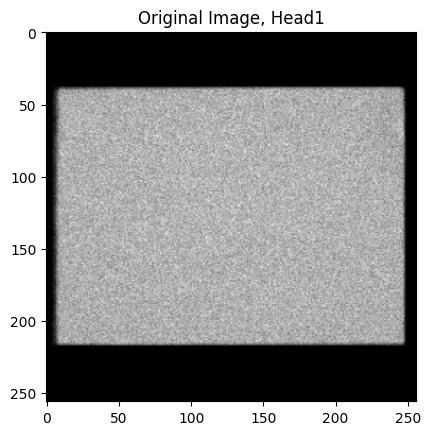

In [147]:
plt.title("Original Image, Head1")
plt.imshow(pixels1, cmap="gray")

In [148]:
pixels1.shape

(256, 256)

In [149]:

im1 = Image.fromarray(pixels1)
print(type(im1))
tiffpath = r"C:\Users\M305747\OneDrive - Mayo Clinic\MPC\medical-physics\NM\Flood Analysis\flood.tiff"
im1.save(tiffpath)
jpg = cv2.imread(tiffpath)
scaled = np.uint8(np.maximum(pixels1, 0) / pixels1.max() * 255)
pixcopy = pixels1.copy()

<class 'PIL.Image.Image'>


In [150]:
pixflat = pixcopy.flatten()
print(type(pixflat))
print(pixflat.max(),pixflat.min())

<class 'numpy.ndarray'>
169 0


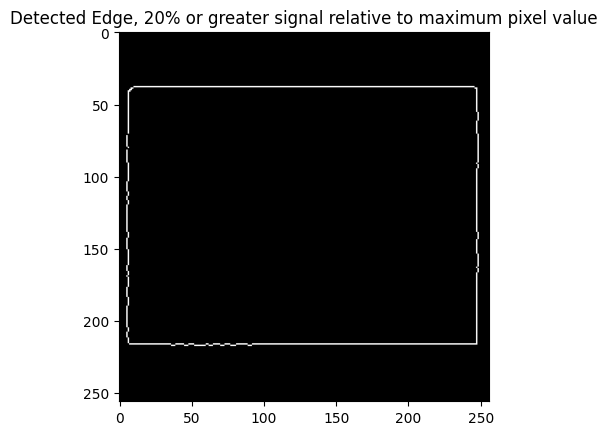

In [151]:
ret,thresh = cv2.threshold(pixcopy,pixcopy.max()*0.20,pixcopy.max(),cv2.THRESH_BINARY)
canny = cv2.Canny(np.uint8(thresh),100,255)
plt.title("Detected Edge, 20% or greater signal relative to maximum pixel value")
plt.imshow(canny,cmap="gray")
plt.show()

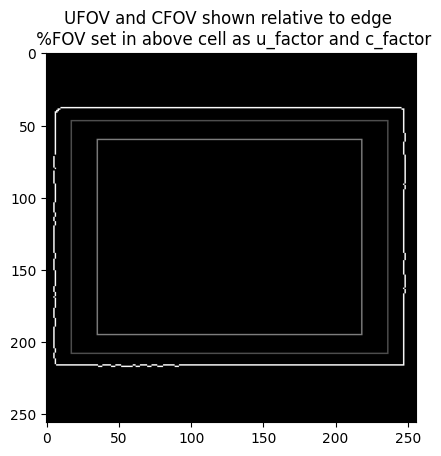

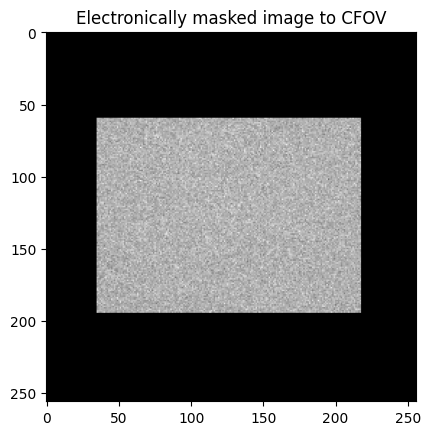

In [152]:
u_factor = 0.9
c_factor = 0.75
cnts, _ = cv2.findContours(canny,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
cntslist = list(cnts)
c = max(cnts,key=cv2.contourArea)
extLeft = tuple(c[c[:, :, 0].argmin()][0])[0]
extRight = tuple(c[c[:, :, 0].argmax()][0])[0]
extTop = tuple(c[c[:, :, 1].argmin()][0])[1]
extBot = tuple(c[c[:, :, 1].argmax()][0])[1]
width = extRight - extLeft
height = extBot - extTop
uwidth = int(width * u_factor)
uheight = int(height * u_factor)
u_width_increment = int((width - uwidth)/2)
u_height_increment = int((height - uheight)/2)
cwidth = int(width * c_factor)
cheight = int(height * c_factor)
c_width_increment = int((width - cwidth)/2)
c_height_increment = int((height - cheight)/2)
u_left,u_right,u_top,u_bot = (extLeft+u_width_increment, extRight - u_width_increment, extTop + u_height_increment, extBot - u_height_increment)
c_left,c_right,c_top,c_bot = (extLeft+c_width_increment, extRight - c_width_increment, extTop + c_height_increment, extBot - c_height_increment)
cv2.rectangle(canny,(u_left,u_top),(u_right,u_bot),80,1)
cv2.rectangle(canny,(c_left,c_top),(c_right,c_bot),125,1)
plt.title("UFOV and CFOV shown relative to edge \n %FOV set in above cell as u_factor and c_factor")
plt.imshow(canny,cmap="gray")
plt.show()
umask = np.zeros(pixcopy.shape,dtype=np.uint8)
cmask = np.zeros(pixcopy.shape,dtype=np.uint8)
umask[u_top:u_bot,u_left:u_right] = 1
cmask[c_top:c_bot,c_left:c_right] = 1

cmasked = cv2.bitwise_and(pixcopy,pixcopy,mask=cmask)
cmasked_copy = cmasked.copy()
plt.title("Electronically masked image to CFOV")
plt.imshow(cmasked,cmap="gray")
plt.show()

In [153]:

image_matrix = cmasked_copy.copy()  
print("image shape",image_matrix.shape)
print(image_matrix.shape, image_matrix.dtype, type(image_matrix))

# Define the bin size
# pixel size = 2.2mm , want ~6.4 mm so bin 3
bin_size = 6

# Calculate the new shape of the matrix after binning
new_shape = (image_matrix.shape[0] // bin_size, bin_size, image_matrix.shape[1] // bin_size, bin_size)
print(new_shape)

# Reshape the matrix into larger blocks
binned_image = image_matrix.reshape(new_shape).mean(axis=(1, 3))

# Print the original and binned images
plt.figure(figsize=(12,12))
plt.imshow(image_matrix)
plt.figure(figsize=(12,12))
plt.imshow(binned_image)


image shape (256, 256)
(256, 256) uint16 <class 'numpy.ndarray'>
(42, 6, 42, 6)


ValueError: cannot reshape array of size 65536 into shape (42,6,42,6)

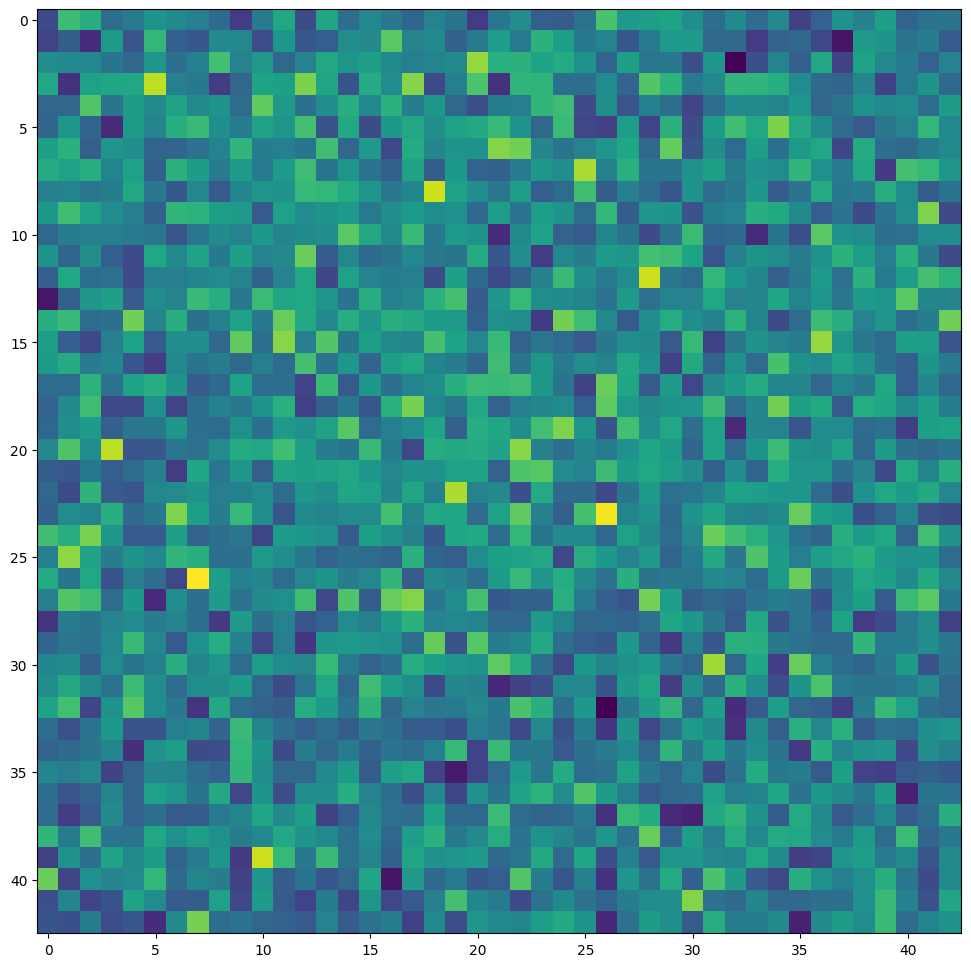

In [129]:
nonzero = np.nonzero(binned_image)
rows = [nonzero[0].min(),nonzero[0].max()]
cols = [nonzero[0].min(),nonzero[0].max()]
trimmed = binned_image[rows[0]:rows[1],cols[0]:cols[1]]
plt.figure(figsize=(12,12))
plt.imshow(trimmed)

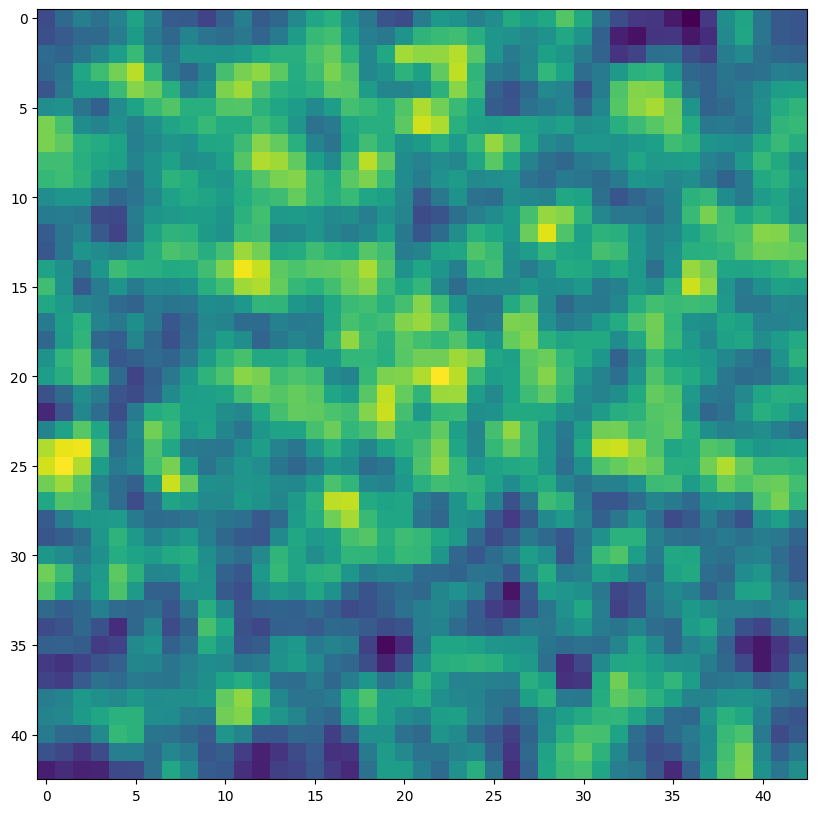

In [130]:
NEMA_kernel = np.array([[1,2,1],[2,4,2],[1,2,1]])
blurred = cv2.filter2D(trimmed,-1,NEMA_kernel)
plt.figure(figsize=(10,10))
plt.imshow(blurred)

In [131]:

#get non-zero 
blurred_nonzero = blurred/ 16 # normalizing values to sum of weighting factors (16) in the NEMA kernel, per instructions
pxmean = blurred_nonzero.mean()
pxmax = blurred_nonzero.max()
pxmin = blurred_nonzero.min()

PIU = (pxmax - pxmin) * 100 / (pxmax + pxmin)
print("mean:",pxmean,"max:",pxmax,"min:",pxmin, "PIU:",round(PIU,2),"%")

mean: 118.01247671413977 max: 122.77083333333334 min: 113.0 PIU: 4.14 %


array([[0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5]])